## Import Libraries

In [1]:
!pip install kaggle
!pip install split-folders

In [98]:
# System tools
import os
import pathlib
import splitfolders
from PIL import Image

# Data handling tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn dependencies
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning dependencies
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Dense, Concatenate, Conv2D, 
MaxPooling2D, GlobalAveragePooling2D, Flatten)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [3]:
# Load from kaggle
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Unzip file
import zipfile
with zipfile.ZipFile('sarscov2-ctscan-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('ct_scans')

In [5]:
# Split into training, validation, and testing set
splitfolders.ratio('ct_scans', output='data_splits', 
                   seed=1337, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None, move=False)

Copying files: 2481 files [00:14, 173.89 files/s]


In [6]:
# Create variables
ds_dir = pathlib.Path('data_splits')
dir_train = pathlib.Path('data_splits/train')
dir_val = pathlib.Path('data_splits/val')
dir_test = pathlib.Path('data_splits/test')

print("Training data qty: ", len(list(dir_train.glob('*/*.png'))))
print("Validation data qty: ", len(list(dir_val.glob('*/*.png'))))
print("Testing data qty: ", len(list(dir_test.glob('*/*.png'))))

Training data qty:  1736
Validation data qty:  495
Testing data qty:  250


## Explore Images

**Covid images**

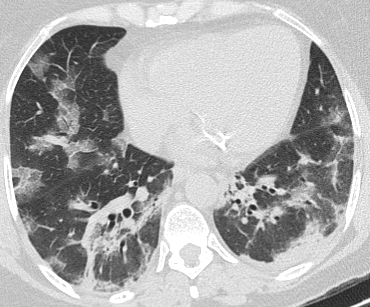

In [7]:
covid = list(dir_train.glob('COVID/*'))

# Covid example one
Image.open(covid[0])

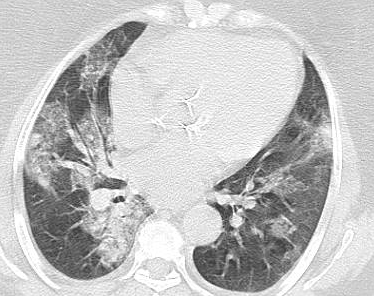

In [8]:
# Covid example two
Image.open(covid[5])

**Non-covid images**

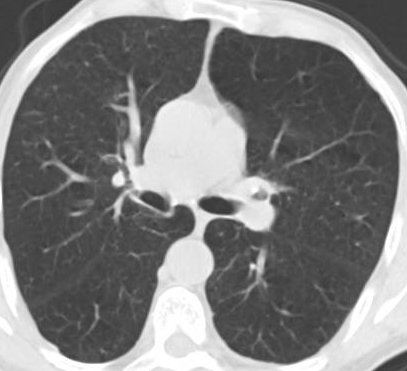

In [9]:
non_covid = list(dir_train.glob('non-COVID/*'))

# Non-covid example one
Image.open(non_covid[0])

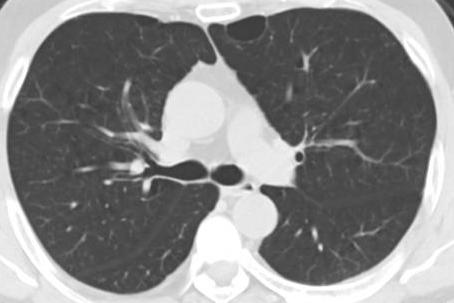

In [10]:
# Non-covid example two
Image.open(non_covid[5])

## Create Dataset

In [11]:
# Define parameters
batch_size = 32
img_height = 224
img_width = 224

In [89]:
# Define data generator function
def data_gen(data_dir, img_height, img_width, batch_size):
    
    data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # Directory to dataset
    directory = data_dir
    
    # Training set
    train_set = data_gen.flow_from_directory('data_splits/train', target_size=(img_height, img_width),
                                           class_mode='categorical', batch_size=batch_size)
    
    # Validation set
    val_set = data_gen.flow_from_directory('data_splits/val', target_size=(img_height, img_width),
                                           class_mode='categorical', batch_size=batch_size, shuffle=True)
    
    # Test set
    test_set = data_gen.flow_from_directory('data_splits/test', target_size=(img_height, img_width), 
                                            class_mode='categorical', batch_size=batch_size, shuffle=False)
    
    return train_set, val_set, test_set

train_data, val_data, test_data = data_gen(ds_dir, img_height, img_width, batch_size);

Found 1736 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [23]:
# Binary classification
train_class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'non-COVID': 1}


## Model Building

**Create model architecture**

In [14]:
# Define input shape and number of classes
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_data.class_indices.keys()))

# Create ResNet50 model with pre-trained weights
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

# Create a new Sequential model and add the ResNet50 layers
model = Sequential()
model.add(resnet)

# Flatten the output of the ResNet50 layers
model.add(Flatten())

# Add a dense layer with softmax activation
model.add(Dense(class_count, activation='softmax'))

# Compile the model with a specified loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate= 0.001),
              metrics=['accuracy'])

In [15]:
# Model summary
model.summary()

# Train the model with early stopping and data augmentation
history = model.fit(train_data,
                        epochs=25,
                        validation_data=val_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/25
55/55 [==============================] - 344s 6s/step - loss: 1.9307 - accuracy: 0.8641 - val_loss: 1.8863 - val_accuracy: 0.7960
Epoch 2/25
55/55 [==============================] - 333s 6s/step - loss: 0.2910 - accuracy: 0.9591 - val_loss: 0.8270 - val_accuracy: 0.9232
Epoch 3/25
55/55 [===

**Visualizing model metrics**

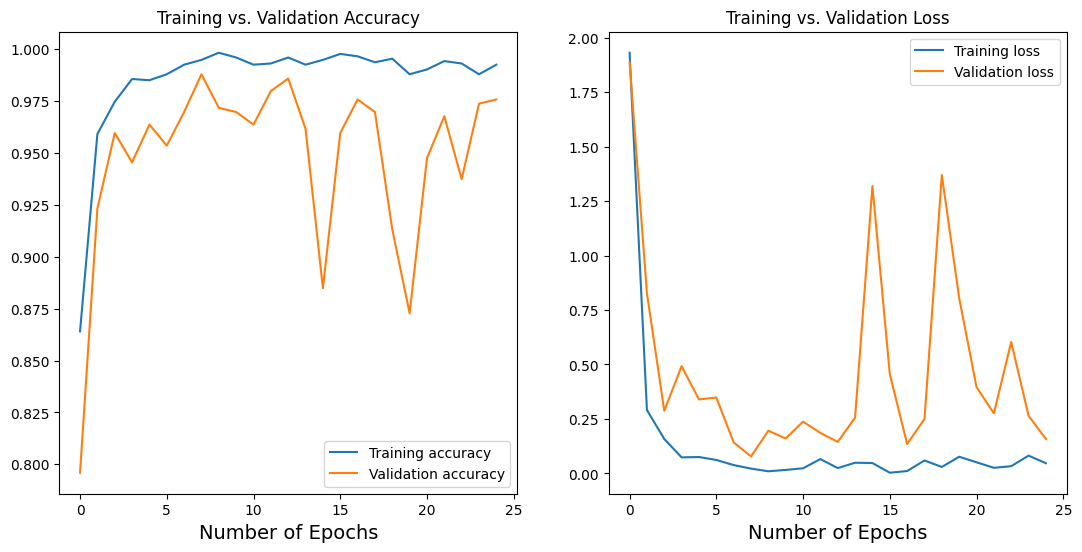

In [16]:
num_epochs = 25

def plot_accuracy_loss(model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(num_epochs)
    
    # Training vs validation accuracy
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    plt.legend()
    
    # Training vs validation loss
    plt.subplot(1,2,2)
    plt.title("Training vs. Validation Loss")
    plt.plot(epochs_range, loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    plt.show()

# Plot accuracy and validation comparisons
plot_accuracy_loss(history)

In the first graph, both the training and validation accuracy linearly increase overtime with both accuracies capping at around 0.90-1.00. While techniques like data augmentation and dropout regularization are commonly used to address overfitting, the margins between the training and validation accuracy indicate a relatively good fit. However, we will still introduce data augmentation to see if the model can perform better.

In the second graph, the training loss appears to smoothly descend plateauing near the zero line while the training loss is not as smooth. 

## Predictions 

**Predict test dataset**

8/8 [==============================] - 10s 1s/step
This CT scan is indicative of a COVID patient with a 73.11 percent confidence.


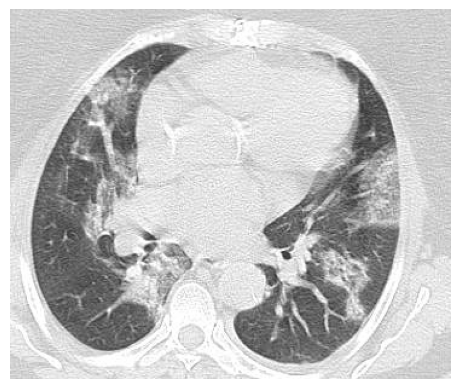

This CT scan is indicative of a COVID patient with a 73.11 percent confidence.


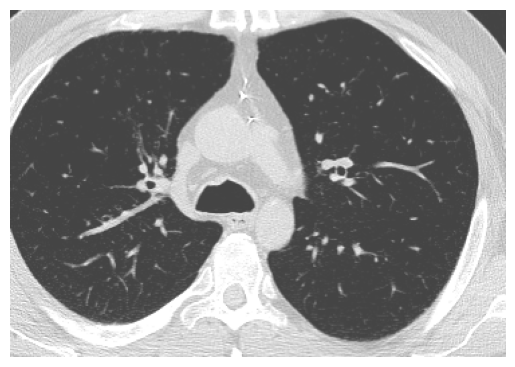

This CT scan is indicative of a COVID patient with a 73.11 percent confidence.


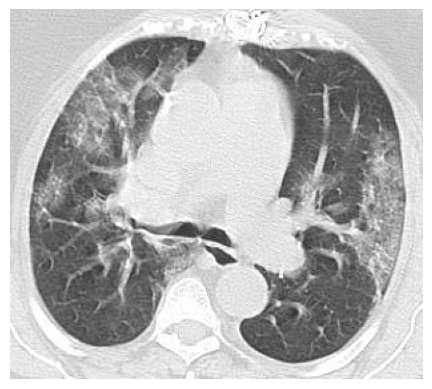

In [131]:
# Predict on test data
y_pred = model.predict(test_data)

# Test data images
images = list(dir_test.glob('COVID/*'))

# Results of first three images
for i in range(0, 3):
    score = tf.nn.softmax(y_pred[i])

    # Print corresponding prediction and image
    
    print(
        "This CT scan is indicative of a {} patient with a {:.2f} percent confidence."
        .format(list(test_data.class_indices.keys())[np.argmax(score)], 100 * np.max(score))
    )
    
    img = Image.open(images[i])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [22]:
# Predictions
y_pred_v2 = np.argmax(y_pred, axis=1)
print(y_pred_v2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       126
           1       0.99      0.94      0.97       124

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



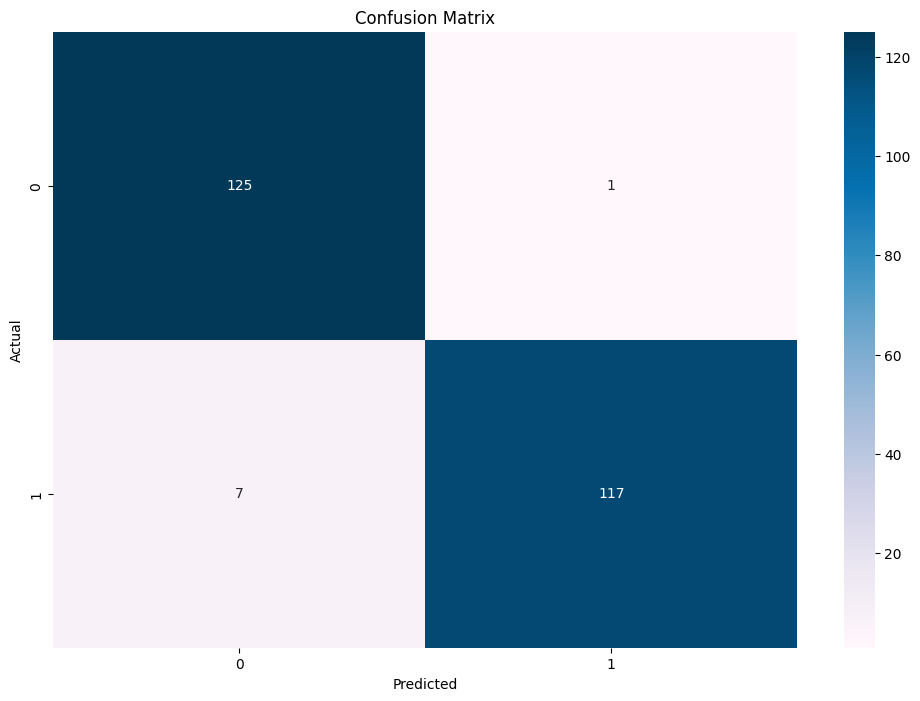

In [74]:
# Evaluate model
test_class_names = test_data.class_indices
classes = list(test_class_names.keys())

# Classification report
print(classification_report(test_data.classes, y_pred_v2))

# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred_v2)
plt.figure(figsize=(12,8))
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='PuBu')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.title('Confusion Matrix')
plt.show();

In [132]:
# Final loss/accuracy scores
final_loss, final_accuracy = model.evaluate(test_data)

8/8 [==============================] - 10s 1s/step - loss: 0.2360 - accuracy: 0.9680
